In [9]:
%cd /Users/masha/Documents/visual-reasoning

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import kornia.geometry.transform as K
import cv2
import random

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

BATCH_SIZE = 32
IMG_SIZE = 224
BLOCK_SIZE = 20
LR = 1e-3
EPOCHS = 30
SUBDIVISION_CAP = 4

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

/Users/masha/Documents/visual-reasoning


In [13]:
# --- CHIRAL SHAPES (Asymmetric Only) ---
CHIRAL_SHAPES = {
    'Tetris_L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'Tetris_J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'Tetris_S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Tetris_Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
    'Pento_F':  [(0, 0), (0, -1), (1, -1), (-1, 0), (0, 1)],
    'Pento_P':  [(0, 0), (0, -1), (1, -1), (1, 0), (0, 1)],
}

def draw_shape(shape_name):
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
    center = IMG_SIZE // 2
    for dx, dy in CHIRAL_SHAPES[shape_name]:
        x = center + (dx * BLOCK_SIZE) - (BLOCK_SIZE // 2)
        y = center + (dy * BLOCK_SIZE) - (BLOCK_SIZE // 2)
        cv2.rectangle(img, (x, y), (x + BLOCK_SIZE, y + BLOCK_SIZE), 255, -1)
    return img

class TetrisPairDataset(Dataset):
    def __init__(self, n_samples=2000, is_train=True):
        self.data = []
        keys = list(CHIRAL_SHAPES.keys())
        
        print(f"Generating {n_samples} pairs...")
        for _ in range(n_samples):
            shape = random.choice(keys)
            base_img = draw_shape(shape)
            
            angle_start = np.random.randint(0, 360)
            
            angle_diff = np.random.randint(30, 150)
            angle_end = angle_start + angle_diff
            
            # Helper to rotate using CV2 for high quality generation
            def rot_cv2(img, ang, flip=False):
                M = cv2.getRotationMatrix2D((IMG_SIZE//2, IMG_SIZE//2), ang, 1.0)
                out = cv2.warpAffine(img, M, (IMG_SIZE, IMG_SIZE))
                if flip: out = cv2.flip(out, 1)
                _, out = cv2.threshold(out, 127, 255, cv2.THRESH_BINARY)
                return out

            x0_img = rot_cv2(base_img, angle_start)
            
            label = 1.0 # Default Same
            if not is_train and np.random.rand() > 0.5:
                # Create Impossible Pair (Mirrored)
                x1_img = rot_cv2(base_img, angle_end, flip=True)
                label = 0.0
            else:
                # Create Valid Pair
                x1_img = rot_cv2(base_img, angle_end, flip=False)
            
            def to_tensor(img):
                t = torch.tensor(img).float() / 255.0
                t = t.unsqueeze(0).repeat(3, 1, 1)
                t = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)(t)
                return t
            
            self.data.append((to_tensor(x0_img), to_tensor(x1_img), torch.tensor(label)))

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

train_ds = TetrisPairDataset(n_samples=800, is_train=True)
test_ds  = TetrisPairDataset(n_samples=200, is_train=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE)

Generating 800 pairs...
Generating 200 pairs...


In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class FlowReasoningModel(nn.Module):
    def __init__(self, backbone, backbone_dim=384, flow_dim=64):
        super().__init__()
        
        # Frozen Backbone
        self.backbone = backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, flow_dim * 4),
            nn.GELU(),
            nn.Linear(flow_dim * 4, flow_dim * 4)
        )

        # Encoder (64x64)
        self.inc = DoubleConv(3, flow_dim)            
        self.down1 = Down(flow_dim, flow_dim * 2)     
        self.down2 = Down(flow_dim * 2, flow_dim * 4) # Bottleneck
        
        # Projection
        self.cond_proj = nn.Linear(backbone_dim, flow_dim * 4)

        # Decoder
        self.up1 = Up(flow_dim * 6, flow_dim * 2) 
        self.up2 = Up(flow_dim * 3, flow_dim)
        self.outc = nn.Conv2d(flow_dim, 3, kernel_size=1)

    def forward(self, x_t, t, x0_clean):
        with torch.no_grad():
            x0_high = F.interpolate(x0_clean, size=(224, 224), mode='bilinear', align_corners=False)
            feats = self.backbone.forward_features(x0_high)
            cls_token = feats[:, 0, :] 

        t_emb = self.time_mlp(t)             
        cond = self.cond_proj(cls_token)     
        global_cond = (t_emb + cond).unsqueeze(-1).unsqueeze(-1)

        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        # Inject Reasoning
        x3 = x3 + global_cond
        
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.outc(x)

dinov3 = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()
model = FlowReasoningModel(backbone=dinov3).to(DEVICE)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)

In [16]:
def get_best_alignment_angle(x0, x1):
    """
    Finds the angle that maps x0 to x1. 
    Since this is 2D Tetris, this heuristic should be almost 100% accurate.
    """
    B = x0.shape[0]
    angles = torch.linspace(0, 360, 36, device=DEVICE) # Check every 10 deg
    
    best_mse = torch.full((B,), float('inf'), device=DEVICE)
    best_ang = torch.zeros((B,), device=DEVICE)
    
    for ang in angles:
        ang_batch = torch.full((B,), ang.item(), device=DEVICE)
        x_rot = K.rotate(x0, ang_batch)
        mse = torch.mean((x_rot - x1)**2, dim=[1, 2, 3])
        
        mask = mse < best_mse
        best_mse[mask] = mse[mask]
        best_ang[mask] = ang_batch[mask]
        
    return best_ang

# Quick Sanity Check
print("Testing Heuristic on a batch...")
x0, x1, _ = next(iter(train_loader))
x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
guessed_angles = get_best_alignment_angle(x0, x1)
print(f"Guessed Angles (First 5): {guessed_angles[:5].cpu().numpy()}")

Testing Heuristic on a batch...
Guessed Angles (First 5): [ 92.57143  92.57143  92.57143 267.42856  92.57143]


In [17]:
print(f"Starting Recursive Training (Segments={SUBDIVISION_CAP})...")
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for x0, x1, _ in train_loader:
        x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
        B = x0.shape[0]
        
        # 1. Discover the Arc (Heuristic)
        with torch.no_grad():
            theta_total = get_best_alignment_angle(x0, x1)
        
        # 2. Pick a Random Segment
        # We split the full arc into N pieces. Pick one to train on.
        k = torch.randint(0, SUBDIVISION_CAP, (B,), device=DEVICE)
        seg_len = 1.0 / SUBDIVISION_CAP
        
        t_start_global = k.float() * seg_len
        t_end_global   = (k.float() + 1) * seg_len
        
        # 3. Generate Waypoints (Recursive Inputs)
        ang_start = theta_total * t_start_global
        ang_end   = theta_total * t_end_global
        
        with torch.no_grad():
            # Create the start and end of this micro-segment
            x_seg_start = K.rotate(x0, ang_start)
            x_seg_end   = K.rotate(x0, ang_end)
            
            # (Optional) If it's the very last segment, force target to match x1
            # x_seg_end[k == SUBDIVISION_CAP-1] = x1[k == SUBDIVISION_CAP-1]

        # 4. Train Flow on Micro-Segment
        t_local = torch.rand(B, 1, device=DEVICE)
        t_view = t_local.view(B, 1, 1, 1)
        
        # Interpolate x_t
        x_t = (1 - t_view) * x_seg_start + t_view * x_seg_end
        
        # Target Velocity
        target_v = x_seg_end - x_seg_start
        
        # Global Time (for conditioning)
        t_global = t_start_global.view(B, 1) + (t_local * seg_len)
        
        # Predict
        pred_v = model(x_t, t_global, x0)
        loss = F.mse_loss(pred_v, target_v)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    avg = epoch_loss / len(train_loader)
    train_losses.append(avg)
    print(f"Epoch {epoch+1}/{EPOCHS} Loss: {avg:.5f}")

plt.plot(train_losses)
plt.show()

Starting Recursive Training (Segments=4)...
Epoch 1/30 Loss: 0.64882
Epoch 2/30 Loss: 0.54081
Epoch 3/30 Loss: 0.53243
Epoch 4/30 Loss: 0.52584
Epoch 5/30 Loss: 0.51862
Epoch 6/30 Loss: 0.52116
Epoch 7/30 Loss: 0.51456
Epoch 8/30 Loss: 0.51079
Epoch 9/30 Loss: 0.50250
Epoch 10/30 Loss: 0.50539
Epoch 11/30 Loss: 0.49875
Epoch 12/30 Loss: 0.51328
Epoch 13/30 Loss: 0.49828
Epoch 14/30 Loss: 0.49124
Epoch 15/30 Loss: 0.49067
Epoch 16/30 Loss: 0.47061
Epoch 17/30 Loss: 0.46653
Epoch 18/30 Loss: 0.47751


KeyboardInterrupt: 

Visualizing Sample (Label: 1.0)


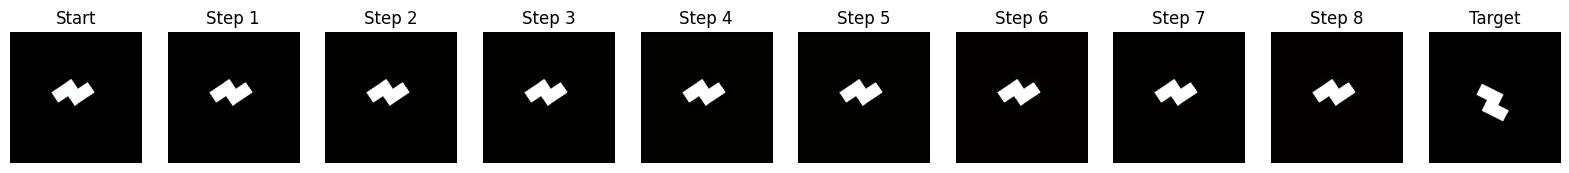

In [23]:
@torch.no_grad()
def solve_flow(model, x_start, steps=8):
    model.eval()
    dt = 1.0 / steps
    curr = x_start.clone()
    frames = [curr.cpu()]
    
    for i in range(steps):
        t = torch.full((x_start.shape[0], 1), i/steps, device=DEVICE)
        v = model(curr, t, x_start)
        curr = curr + v * dt
        frames.append(curr.cpu())
    return frames

# Visualize a Test Pair
idx = 4
x0_vis = test_ds[idx][0].unsqueeze(0).to(DEVICE)
x1_vis = test_ds[idx][1].unsqueeze(0).to(DEVICE) # True Target
label  = test_ds[idx][2].item()

print(f"Visualizing Sample (Label: {label})")
frames = solve_flow(model, x0_vis, steps=8)

fig, axes = plt.subplots(1, 10, figsize=(20, 3))

def show(ax, t, title):
    img = t[0].permute(1,2,0).numpy()
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title)
    ax.axis('off')

show(axes[0], x0_vis.cpu(), "Start")
for i in range(8): 
    show(axes[i+1], frames[i+1], f"Step {i+1}")
show(axes[9], x1_vis.cpu(), "Target")
plt.show()

Checking Alignment Heuristic on Test Set...
Angle      | MSE Error  | Status
-----------------------------------
   0.0°   | 0.6432     | Perspective Mismatch
  92.6°   | 0.1755     | Good Match
  92.6°   | 0.4641     | Good Match
  92.6°   | 0.4628     | Good Match
  92.6°   | 0.5228     | Perspective Mismatch


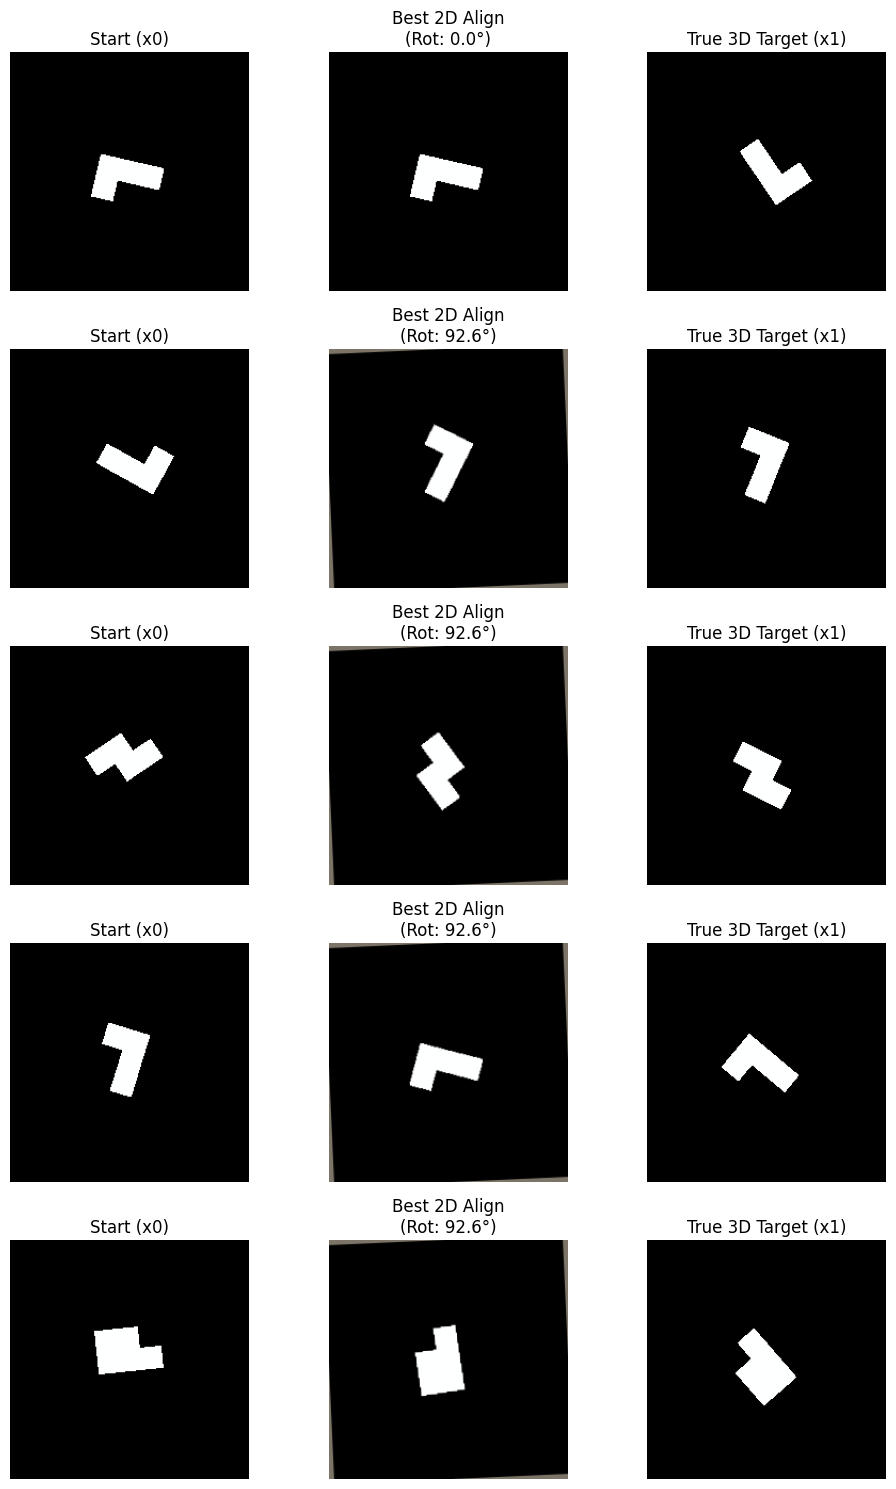

In [ ]:
def visualize_alignment_heuristic(loader, num_samples=5):
    """
    Visualizes what the 'Best Alignment' function actually produces.
    Compares: Start -> Best 2D Rotation -> True 3D Target
    """
    x0, x1, labels = next(iter(loader))
    x0, x1 = x0.to(DEVICE), x1.to(DEVICE)
    
    mask = (labels == 1.0)
    x0 = x0[mask][:num_samples]
    x1 = x1[mask][:num_samples]
    
    if len(x0) == 0:
        print("No 'same' pairs found in this batch to visualize.")
        return

    with torch.no_grad():
        # Find best angle
        best_angles = get_best_alignment_angle(x0, x1)
        
        # Generate the aligned image
        x_aligned = K.rotate(x0, best_angles)
        mse = torch.mean((x_aligned - x1)**2, dim=[1, 2, 3])

    fig, axes = plt.subplots(len(x0), 3, figsize=(10, 3 * len(x0)))
    if len(x0) == 1: axes = [axes] # Handle single row case

    def denorm(t):
        img = t.cpu().permute(1, 2, 0).numpy()
        img = (img * IMAGENET_STD) + IMAGENET_MEAN
        return np.clip(img, 0, 1)

    print(f"{'Angle':<10} | {'MSE Error':<10} | {'Status'}")
    print("-" * 35)

    for i in range(len(x0)):
        # Metrics
        ang = best_angles[i].item()
        err = mse[i].item()
        status = "Good Match" if err < 0.5 else "Perspective Mismatch"
        print(f"{ang:>6.1f}°   | {err:>6.4f}     | {status}")

        # Draw
        ax_row = axes[i] if len(x0) > 1 else axes
        
        ax_row[0].imshow(denorm(x0[i]))
        ax_row[0].set_title("Start (x0)")
        ax_row[0].axis('off')
        
        ax_row[1].imshow(denorm(x_aligned[i]))
        ax_row[1].set_title(f"Best 2D Align\n(Rot: {ang:.1f}°)")
        
        color = 'green' if err < 0.3 else 'orange'
        for spine in ax_row[1].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
        ax_row[1].axis('off')

        ax_row[2].imshow(denorm(x1[i]))
        ax_row[2].set_title("True 3D Target (x1)")
        ax_row[2].axis('off')

    plt.tight_layout()
    plt.show()

visualize_alignment_heuristic(test_loader, num_samples=5)